In [1]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import nltk

In [2]:
#!pip install tensorflow-gpu==2.2.0
#!pip install ktrain

In [3]:
import ktrain 
from ktrain import text

In [4]:
df_alexa = pd.read_csv('amazon_alexa.tsv', sep='\t')

In [5]:
df_alexa.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
df_alexa = df_alexa.dropna()

In [7]:
df_alexa.shape

(3150, 5)

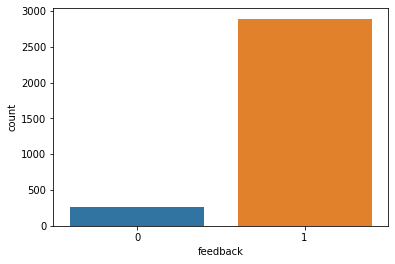

In [8]:
sns.countplot(df_alexa['feedback'], label = "Count") 

In [9]:
positive = df_alexa[df_alexa['feedback']==1]
negative = df_alexa[df_alexa['feedback']==0]

In [10]:
words = df_alexa['verified_reviews'].tolist()

In [11]:
from nltk import word_tokenize
def ultimate_tokenize(sentence):
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    return word_tokenize(sentence.lower())

In [12]:
def cleaning(raw_review):
    
    tokens = ultimate_tokenize(raw_review)
    from nltk.corpus import stopwords

    stops = stopwords.words('english')
    stops.extend('.,[,],(,),;,/,-,\',?,",:,<,>,n\'t,|,#,\'s,\",\'re,\'ve,\'ll,\'d,\'re,’'.split(','))
    stops.extend(',')
    
    # 6. Remove stop words. 
    words = [w for w in tokens if not w in stops]
    
    # 7. Stemming
    words = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]
    
    return " ".join(words)


In [13]:
df_alexa['clean_reviews']=df_alexa['verified_reviews'].apply(cleaning)
df_alexa.head()

,rating,date,variation,verified_reviews,feedback,clean_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,love
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,sometim play game answer question correct alex...
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing yr old learn dinosaur control li...
4,5,31-Jul-18,Charcoal Fabric,Music,1,music


In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [18]:
x = df_alexa['clean_reviews'].tolist()
x

['love echo',
 'love',
 'sometim play game answer question correct alexa say got wrong answer like abl turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music well',
 'music',
 'receiv echo gift need anoth bluetooth someth play music easili access found smart speaker wait see els',
 'without cellphon use mani featur ipad see use great alarm u r almost deaf hear alarm bedroom live room reason enough keep herit fun ask random question hear respons seem smartbon polit yet',
 'think th one ive purchas im work get one everi room hous realli like featur offer specifili play music echo control light throughout hous',
 'look great',
 'love listen song heard sinc childhood get news weather inform great',
 'sent year old dad talk constant',
 'love learn knew thing eveyday still figur everyth work far easi use understand make laugh time',
 'purchas mother knee problem give someth tri come get around fast like didsh enjoy littl big t

In [19]:
y = df_alexa['feedback'].tolist()

In [20]:
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=0.5)
#Effective Train-70%, Validation-15%, Test-15% breakup

In [21]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                       x_test=x_test, y_test=y_test,
                                                                       class_names=['0', '1'],
                                                                       preprocess_mode='bert',
                                                                       ngram_range=1, 
                                                                       maxlen=320)

task: text classification
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [22]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), batch_size=4)

Is Multi-Label? False
maxlen is 320
done.


In [23]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 320)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 320)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 320, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 320, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [24]:
hist = learner.fit_onecycle(1e-5, 2) 



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
552/552 [==============================] - 14652s 27s/step - loss: 0.2917 - accuracy: 0.8907
Epoch 2/2
552/552 [==============================] - 67040s 121s/step - loss: 0.1764 - accuracy: 0.9347


In [25]:
learner.validate(val_data=(x_test, y_test))

              precision    recall  f1-score   support

           0       0.56      0.27      0.36        37
           1       0.94      0.98      0.96       436

    accuracy                           0.93       473
   macro avg       0.75      0.63      0.66       473
weighted avg       0.91      0.93      0.91       473



array([[ 10,  27],
       [  8, 428]], dtype=int64)

In [26]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [30]:
x_pred_val = predictor.predict(x_val)

In [31]:
x_pred_val_num = list(map(int,x_pred_val))
x_pred_val_num

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [32]:
y_val

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [33]:
c=0
for i in range(len(y_val)):
    if y_val[i]==x_pred_val_num[i]:
        c+=1
print("Accuracy:",(c/len(y_val)))

Accuracy: 0.9385593220338984
